In [95]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt




In [96]:
def use_tflite_load(modelfile):
    # Load TFLite model and allocate tensors.
    interpreter = tf.lite.Interpreter(model_path=modelfile)
    interpreter.allocate_tensors()
    return interpreter


def use_tflite_predict(xs, tf_interpreter, model_input_size=96, result_img_size=96):
    interpreter = tf_interpreter
    # Get input and output tensors.
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Test model on random input data.
    input_shape = input_details[0]['shape']
    out_imgs = []
    for img in xs:
        #print("imgs:", type(xs), xs.shape, type(xs[0]))
        #img_ori_size = img.shape[0]
        size = model_input_size
        x = cv2.resize(img, (size, size), interpolation=cv2.INTER_AREA).reshape(size, size, 1)
        #print("img:", type(x), x.shape)
        
        x = x[None]
        #input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
        #print(f"input:{input_shape}, x:{x.shape}, type of shape{type(input_shape)}")
        if list(x.shape) == input_shape.tolist():
            input_data = x
        else:
            raise ValueError("image shape error")
        interpreter.set_tensor(input_details[0]['index'], input_data.astype(np.float32))
        interpreter.invoke()
        # The function `get_tensor()` returns a copy of the tensor data.
        # Use `tensor()` in order to get a pointer to the tensor.
        output_data = interpreter.get_tensor(output_details[0]['index'])
        size = result_img_size
        out_img = cv2.resize(output_data[0], (size, size), interpolation=cv2.INTER_AREA).reshape(size, size, output_data.shape[-1])
        out_imgs.append(out_img)
    return out_imgs

In [97]:
tflite = r"F:\workspace\tf2.0_out\linknet18_32_0.5_multi_96\linknet_model7.0posi.tflite"
imagefile = r"F:\workspace\testSet\testSet5.0_lit\03_04L01\frm-0010.png"
img = cv2.imread(imagefile, cv2.IMREAD_GRAYSCALE)
clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(7, 7))
img = clahe.apply(img)
imgs = np.array([img[..., None]])
tf_interpreter = use_tflite_load(tflite)
ypred = use_tflite_predict(imgs, tf_interpreter, 96)
print(ypred[0].shape)


(96, 96, 4)


In [98]:
def prune_components(img, min_area_per=0.002, deep_prune=True):
    image, contours, hier = cv2.findContours(img[:,:,3].astype(np.uint8),
                                                    cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # for each contour
    mask = np.zeros(image.shape, dtype=np.uint8)

    min_area = mask.size * min_area_per
    print(min_area)
    # sort contours by area
    areas = np.array([cv2.contourArea(c) for c in contours])
    print("areas:", areas)
    area_idx = np.argsort(areas)[::-1]
    print("idx:", area_idx)
    areas = areas[area_idx]
    print("areas:", areas)
    sorted_contours = np.array([c for c in contours])[area_idx]

    # get rid of small contours
    sorted_contours = np.array(sorted_contours)[areas>=min_area]
    #for cnt in sorted_contours:
    cv2.drawContours(mask, sorted_contours, -1, 1, -1)
    
    return mask

In [99]:
for i in ypred:
    msk=prune_components(i)

18.432000000000002
areas: [4441.5 2461.5]
idx: [0 1]
areas: [4441.5 2461.5]


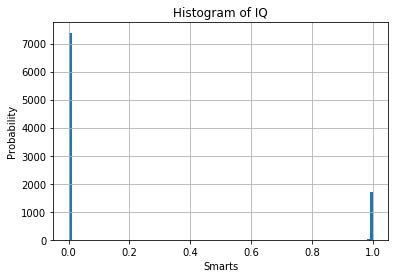

In [138]:
datas = ypred[0][:,:,0].flatten()
#n, bins, patches = plt.hist(datas, 100, density=False, facecolor='g', alpha=0.75)
plt.hist(datas, bins=100)
#plt.eventplot(datas)
#plt.scatter(datas, datas)
#plt.plot(data)
plt.xlabel('Smarts')
plt.ylabel('Probability')
plt.title('Histogram of IQ')
#plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
#plt.xlim(0, 10000)
#plt.ylim(0, 1)
plt.grid(True)
plt.show()

In [91]:
y0 = ypred[0][:,:,2]
x0 = img

print(x0.shape, y0.shape)
s = (448, 448)
x = cv2.resize(x0, s)
y = cv2.resize(y0, s)

img2 = cv2.cvtColor(x, cv2.COLOR_GRAY2BGR)
msk2 = cv2.cvtColor(y, cv2.COLOR_GRAY2BGR)

mask_show = (msk2*255).astype(np.uint8)
mask_show = clahe.apply(img)
cv2.imshow("msk", mask_show)
print("2:", img2.shape, msk2.shape, img2.dtype, msk2.dtype)
cmsk = np.zeros(msk2.shape)
cmsk[:,:,0]=128
cmsk[:,:,1]= y*255
cmsk[:,:,2]= y*255
msk2 = cmsk.astype(np.uint8)
img3 = cv2.add(img2, msk2)


cv2.imshow("img3", img3)
cv2.waitKey(0)
cv2.destroyAllWindows()

(448, 448) (96, 96)
2: (448, 448, 3) (448, 448, 3) uint8 float32
